In [6]:
#Import the meaningful libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
import numpy as np
from random import choices

class0 = 0
class1 = 1

train_dataset = MNIST(root='./data', train=True, download=True)

xtrain = train_dataset.data[(train_dataset.targets == class0)|(train_dataset.targets == class1)].data.numpy() #.astype(float)[0:sample] 


In [ ]:
# questa funzione genera un array che corrisponde alla rilevazione di n fotoni 
#The function in this cell generates an array that corresponds to the detection of n photons
#of an image y, after blurring.
# n : number of photons
# sigma is the blurring parameter
# y array 28 x 28

def sampling_direct_intensity(y, sigma, n):
    ypad = np.pad(y, ((28,28) , (28,28)), mode = 'constant', constant_values=(0, 0))
    p_DI = np.zeros(ypad.shape)
    for i in range(ypad.shape[0]):
        for j in range(ypad.shape[1]):
            p_DI[i,j] = np.sum( [ypad[u,v]*np.exp( - ((i - u)**2 + (j - v)**2) / (2*sigma**2) ) 
                                 for u in range(28,56) for v in range(28,56)] ) / ( 2*np.pi*sigma**2 )
    P_norm = p_DI/ np.linalg.norm(p_DI, 1)
    
    f_DI = np.zeros(ypad.shape)
    for i in range(ypad.shape[0]):
        for j in range(ypad.shape[1]):
            p0 = P_norm[i,j]
            f_DI[i,j] = np.random.binomial(n, p0, 1)
    f_norm = f_DI/ np.linalg.norm(f_DI, 1)
    return f_norm

In [ ]:
# exemple visualization

y = x_train[56]
sigma = 1

finites1 = sampling_direct_intensity(y, sigma, 1)
finites2 = sampling_direct_intensity(y, sigma, 1000)
finites3 = sampling_direct_intensity(y, sigma, 5000)
finites4 = sampling_direct_intensity(y, sigma, 10000)

# Visualize the direct intensity measurement
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax[0,0].imshow(finites1, cmap='gray') #, vmin=0, vmax=np.max(y))
ax[0,0].set_title('100 fotoni')
ax[1,0].imshow(finites2, cmap='gray') #, vmin=0, vmax=np.max(P_norm))
ax[1,0].set_title('1000 fotoni')
ax[0,1].imshow(finites3, cmap='gray') #, vmin=0, vmax=np.max(y))
ax[0,1].set_title('5000 fotoni')
ax[1,1].imshow(finites4, cmap='gray') #, vmin=0, vmax=np.max(y))
ax[1,1].set_title('10000 fotoni')
plt.show()

In [8]:
#
# pre-processing SPADE
#
# SPADE_preprocessing(y, sigma, n)
#
# where:
#   y is 28x28 array (from MNIST)
#   sigma is blurring parameter (float)
#   n is number of photons (int)


####

### SPADE pre-processing

def SPADE_intensity(y, sigma, f): # sigma >0
    med = 14
    
    # order 0
    HG00 = np.sum( [[y[i,j] * np.exp( -( (i-med)**2 + (j-med)**2 ) / (4 * (sigma/f)**2) ) 
                     for i in range(28)] for j in range(28)] )
    # order 1
    HG01 = np.sum( [[y[i,j] * ( f*(j-med) )**2 * np.exp( -( (i-med)**2 + (j-med)**2 ) / (4 * (sigma/f)**2)) 
                     for i in range(28)] for j in range(28)] ) / (4 * sigma**2)
    HG10 = np.sum( [[y[i,j] * ( f*(i-med) )**2 * np.exp( -( (i-med)**2 + (j-med)**2 ) / (4 * (sigma/f)**2)) 
                     for i in range(28)] for j in range(28)] ) / (4 * sigma**2)
    # order 2
    HG11 = np.sum( [[y[i,j] * ( f*(j-med) )**2 * ( f*(i-med) )**2 * np.exp( -( (i-med)**2 + (j-med)**2 ) / (4 * (sigma/f)**2) ) 
                     for i in range(28)] for j in range(28)] ) / (16 * sigma**4)
    HG02 = np.sum( [[y[i,j] * ( f*(j-med) )**4 * np.exp( -( (i-med)**2 + (j-med)**2 ) / (4 * (sigma/f)**2)) 
                     for i in range(28)] for j in range(28)] ) / (32 * sigma**4)
    HG20 = np.sum( [[y[i,j] * ( f*(i-med) )**4 * np.exp( -( (i-med)**2 + (j-med)**2 ) / (4 * (sigma/f)**2)) 
                     for i in range(28)] for j in range(28)] ) / (32 * sigma**4)
        
    norm = HG00 + HG01 + HG10 + HG11 + HG02 + HG20
    pHG00 = HG00 / norm
    pHG01 = HG01 / norm
    pHG10 = HG10 / norm
    pHG11 = HG11 / norm
    pHG02 = HG02 / norm
    pHG20 = HG20 / norm
    return pHG00, pHG01, pHG10, pHG11, pHG02, pHG20 

# input vec is normalised propability
def SPADE_sampling(vec, n):
    pvals = vec
    #print(pvals)
    
    if n==0:
        return pvals

    else:
        data = np.random.multinomial(n, pvals, size=1)
        data = data/ np.sum(data)
        #return [ data[0,1], data[0,2], data[0,3], data[0,4], data[0,5] ]
        return [ data[0,0], data[0,1], data[0,2], data[0,3], data[0,4], data[0,5] ]

# funzione principale
def SPADE_preprocessing(y, sigma, f, n):
    vec = SPADE_intensity(y, sigma, f)
    return SPADE_sampling(vec, n)

In [7]:
#example spade vector
y = x_train[4]
vec = SPADE_intensity(y, sigma=15,f=1)
data = SPADE_sampling(vec, n=1000)
print( SPADE_preprocessing(y, sigma=2, f=1,n=25000) )

[0.534, 0.02432, 0.25036, 0.0122, 0.00136, 0.17776]


In [14]:
#We now preprocess the entire dataset, fixing sigma and varing the scaling factor f

sigma=9.5
values_f = [ 1.3 , 1.2 , 1.1 , 1.0 , 0.9 , 0.8 , 0.7 , 0.6 , 0.5 ]
N=[100,500,1000,5000,10000]
def datas_mult(X,N,sigma):
    D=[[[0 for i in range(len(N))] for j in range(len(valori_f))] for z in range(len(xtrain))]
    for i in range(len(xtrain)):
        for j in range(len(N)):
            for z in range(len(values_f)):
                D[i][z][j]=np.array(SPADE_preprocessing(xtrain[i], sigma=sigma,f=valori_f[z],n=N[j]))
    return D
pre_data=np.array(datas_mult(xtrain,N,sigma))
#and save the results
np.save("preproc_f.npy",pre_data)

In [ ]:
#Random Forest Algorithm
#hyperparm
n_estimators=100 #trees in the RF
cv=20 #number of crossvalidation


y=train_dataset.targets[(train_dataset.targets == class0)|(train_dataset.targets == class1)].numpy()
y=torch.from_numpy(y).to(torch.float64)
accuracy,stdev=[[0 for i in range(len(N))] for j in range(len(values_f))],[[0 for i in range(len(N))] for j in range(len(values_f))]

for a in range(len(sigma)):
    for b in range(len(N)):
        X_train, X_test, y_train, y_test = train_test_split(data[:,a,b,:],y, test_size=0.3,shuffle=True,stratify=y)
        rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
        rf_clf.fit(X_train, y_train)
        cv_score_rf = cross_val_score(rf_clf, X_test, y_test, cv= 20, scoring = "accuracy")
        cv_score_rf_m = np.mean(cv_score_rf)
        cv_score_rf_std=np.std(cv_score_rf)
        accuracy[a][b]=cv_score_rf_m
        stdev[a][b]=cv_score_rf_std
        
        print(cv_score_rf_m,cv_score_rf_std)


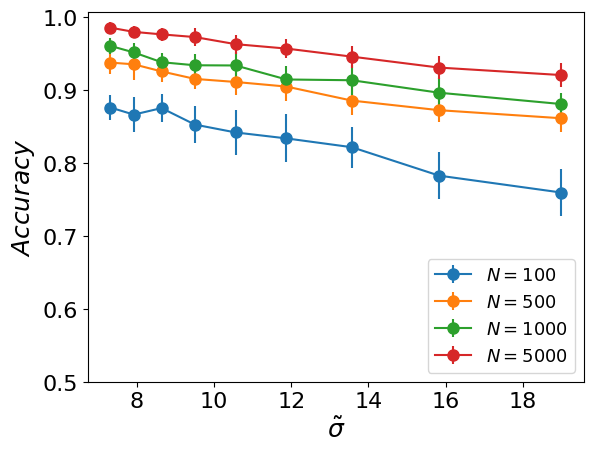

In [30]:
import matplotlib.pyplot as plt
import numpy as np

sigma_real=9.5/np.array([ 1.3 , 1.2 , 1.1 , 1.0 , 0.9 , 0.8 , 0.7 , 0.6 , 0.5 ])
fig = plt.figure()
accuracy=np.array(accuracy)
stdev=np.array(stdev)
plt.errorbar(sigma2, list((accuracy[:,0])), yerr=stdev[:,0], label='$N=100$',marker='o', markersize=8)

plt.errorbar(sigma2, list((accuracy[:,1])), yerr=stdev[:,1], label='$N=500$',marker='o', markersize=8)

plt.errorbar(sigma2, list((accuracy[:,2])), yerr=stdev[:,2],
             label='$N=1000$',marker='o', markersize=8)

plt.errorbar(sigma2, list((accuracy[:,3])), yerr=stdev[:,3],
             label='$N=5000$',marker='o', markersize=8)


#plt.errorbar(sigma, list((accuracy[:,4])), yerr=stdev[:,4],
 #            label='$N=10000$',marker='o', markersize=8)

plt.xticks([8,10,12,14,16,18],fontsize=16)
plt.yticks([0.5,0.6,0.7,0.8,0.9,1.0],fontsize=16)
plt.xlabel(r"$\tilde{\sigma}$",fontsize=18)
plt.ylabel("$Accuracy$",fontsize=18)
plt.legend(loc='lower right',fontsize=13)
plt.savefig("spade_rf_f.pdf", bbox_inches='tight')